In [8]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

import theano.tensor as tt
import pymc3 as pm

# need exoplanet version 0.3.3 for the gp submodule. 
#Should upgrade specgp to use celerite2 eventually. 
import exoplanet as xo
import specgp as sgp
from specgp.distributions import MvUniform

In [10]:
from astropy.table import Table
from types import SimpleNamespace
filename = 'ganymede/Kepler-22b.fits'
data = Table.read(filename)
flux = np.array([data.columns[i] for i in range(len(data.columns)-1)], dtype='float64')
t = np.array(data.columns[-1], dtype='float64')
vars = SimpleNamespace(**data.meta)

estimated white noise: [0.00030717 0.00029515 0.00030504]


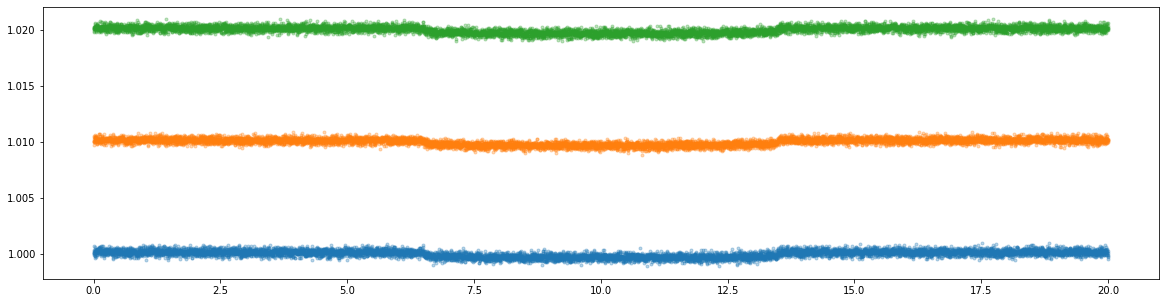

In [11]:
pl.figure(figsize=(20, 5))
for i, f in enumerate(flux):
    pl.plot(t/(60*60), f/np.mean(f) + 0.01*i, '.', alpha=0.3)
wn_est = np.std(flux.T/np.mean(flux, axis=1), axis=0)
print("estimated white noise: {0}".format(wn_est))

In [12]:
obs = np.reshape(np.array([f/np.mean(f) for f in flux]).T, (np.shape(flux.T)[1]*len(t)))

nb = np.shape(flux)[0]
mu = {'logS0':np.log(vars.S0), 'logw':np.log(vars.W0), 'alpha':np.zeros(nb-1), 
      'logsig':np.log(wn_est), 'mean':np.ones(nb), 'u':[0.5, 0.5], 
      'logrp':np.log(vars.RP), 't0p':vars.T0P, 'logrm':np.log(vars.RM), 't0m':vars.T0M}
sig = {'logS0':10, 'logw':10, 'logQ':None, 'alpha':np.ones(nb-1), 
       'logsig':np.ones(nb)*5, 'mean':np.ones(nb)*0.1, 
       't0p':2, 't0m':2, 'logrm':1, 'logrp':1}

def getmodel(holds={}, mu={}, sig={}, transform=False, nterms=1):
    
    params = ['logS0', 'logw', 'alpha', 
             'logsig', 'mean', 'u', 'logrp', 't0p', 't0m']
    for p in params:
        if p not in holds:
            holds[p] = None
        if p not in mu:
            mu[p] = None
        if p not in sig:
            sig[p] = None
    
    with pm.Model() as model:
        logS0 = pm.Normal("logS0", mu=mu["logS0"], 
                        sd=sig["logS0"], observed=holds['logS0'])
        logw = pm.Normal("logw", mu=mu["logw"], 
                       sd=sig["logw"], observed=holds['logw'])
        
        if np.shape(flux)[0] > 1:
            alpha =  pm.MvNormal("alpha", mu=mu["alpha"], 
                          chol=np.diag(sig["alpha"]), shape=np.shape(flux)[0]-1, observed=holds['alpha'])
        logsig = pm.MvNormal("logsig", mu=mu["logsig"], 
                         chol=np.diag(sig["logsig"]), shape=np.shape(flux)[0], observed=holds['logsig'])
        mean = pm.MvNormal("mean", mu=mu["mean"], 
                       chol=np.diag(sig["mean"]), shape=np.shape(flux)[0], observed=holds['mean'])
        u = sgp.distributions.MvUniform("u", lower=[0, 0], upper=[1, 1], 
                                        testval=[0.5, 0.5], observed=holds['u'])
        
        if transform:
            logrp = pm.Uniform("logrp", lower=-20.0, upper=0.0, testval=mu['logrp'], 
                               observed=holds['logrp'])
            t0p = pm.Uniform("t0p", lower=t[0], upper=t[-1], testval=mu['t0p'], 
                             observed=holds['t0p'])
        else:
            logrp = pm.Uniform("logrp", lower=-20.0, upper=0.0, testval=mu['logrp'], 
                           transform=None, observed=holds['logrp'])
            t0p = pm.Uniform("t0p", lower=t[0], upper=t[-1], testval=mu['t0p'], 
                         transform=None, observed=holds['t0p'])
        
        orbit = xo.orbits.SimpleTransitOrbit(period=5.0*60*60, dur=6.977)
        lcp = (xo.LimbDarkLightCurve(u)
              .get_light_curve(orbit=orbit, r=np.exp(logrp), t=t/(60*60)-t0p, texp=np.mean(np.diff(t))/(60*60)))
        mean = mean[:, None] + lcp.T[0]
    
        term = xo.gp.terms.SHOTerm(
                log_S0 = logS0,
                log_w0 = logw,
                log_Q = -np.log(np.sqrt(2))
            )
        
        if np.shape(flux)[0] > 1:
            a = tt.exp(tt.concatenate([[0.0], alpha]))
            kernel = sgp.terms.KronTerm(term, alpha=a)
        else:
            kernel = term
        
        yerr = tt.exp(2 * logsig)
        yerr = yerr[:, None] * tt.ones(len(t))
        
        if np.shape(flux)[0] > 1:
            gp = xo.gp.GP(kernel, t, yerr, J=2, mean=sgp.means.KronMean(mean))
        else:
            gp = xo.gp.GP(kernel, t, yerr[0], J=2, mean=mean)
        marg = gp.marginal("gp", observed = obs.T) 
    return model

nb = np.shape(flux)[0]
mu = {'logS0':np.log(vars.S0), 'logw':np.log(vars.W0), 'alpha':np.zeros(nb-1), 
             'logsig':np.log(wn_est), 'mean':np.ones(nb), 'u':[0.5, 0.5], 'logrp':np.log(vars.RM), 't0p':vars.T0M}
sig = {'logS0':10, 'logw':10, 'logQ':None, 'alpha':np.ones(nb-1), 
             'logsig':np.ones(nb)*5, 'mean':np.ones(nb), 't0p':2}
m = getmodel(mu=mu, sig=sig)
with m:
    map_soln = xo.optimize(start=m.test_point, verbose=True)

TypeError: __init__() got an unexpected keyword argument 'dur'

In [336]:
nb = np.shape(flux)[0]
mu = {'logS0':np.log(vars.S0), 'logw':np.log(vars.W0), 'alpha':np.zeros(nb-1), 
      'logsig':np.log(wn_est), 'mean':np.ones(nb), 'u':[0.5, 0.5], 
      'logrp':np.log(vars.RP), 't0p':vars.T0P, 'logrm':np.log(vars.RM), 't0m':vars.T0M}
sig = {'logS0':10, 'logw':10, 'logQ':None, 'alpha':np.ones(nb-1), 
       'logsig':np.ones(nb)*5, 'mean':np.ones(nb)*0.1, 
       't0p':2, 't0m':2, 'logrm':1, 'logrp':1}

def getmodel(holds={}, mu={}, sig={}, transform=False, nterms=1):
    
    params = ['logS0', 'logw', 'alpha', 
             'logsig', 'mean', 'u', 'logrp', 'logrm', 't0p', 't0m']
    for p in params:
        if p not in holds:
            holds[p] = None
        if p not in mu:
            mu[p] = None
        if p not in sig:
            sig[p] = None
    
    with pm.Model() as model:
        logS0 = pm.Normal("logS0", mu=mu["logS0"], 
                        sd=sig["logS0"], observed=holds['logS0'])
        logw = pm.Normal("logw", mu=mu["logw"], 
                       sd=sig["logw"], observed=holds['logw'])
        
        if np.shape(flux)[0] > 1:
            alpha =  pm.MvNormal("alpha", mu=mu["alpha"], 
                          chol=np.diag(sig["alpha"]), shape=np.shape(flux)[0]-1, observed=holds['alpha'])
        logsig = pm.MvNormal("logsig", mu=mu["logsig"], 
                         chol=np.diag(sig["logsig"]), shape=np.shape(flux)[0], observed=holds['logsig'])
        mean = pm.MvNormal("mean", mu=mu["mean"], 
                       chol=np.diag(sig["mean"]), shape=np.shape(flux)[0], observed=holds['mean'])
        u = sgp.distributions.MvUniform("u", lower=[0, 0], upper=[1, 1], 
                                        testval=[0.5, 0.5], observed=holds['u'])
        
        if transform:
            logrp = pm.Uniform("logrp", lower=-20.0, upper=0.0, testval=mu['logrp'], 
                               observed=holds['logrp'])
            logrm = pm.Uniform("logrm", lower=-20.0, upper=0.0, testval=mu['logrm'], 
                               observed=holds['logrm'])
            t0p = pm.Uniform("t0p", lower=t[0], upper=t[-1], testval=mu['t0p'], 
                             observed=holds['t0p'])
            t0m = pm.Uniform("t0m", lower=t[0], upper=t[-1], testval=mu['t0m'],
                             observed=holds['t0m'])
        else:
            logrp = pm.Uniform("logrp", lower=-20.0, upper=0.0, testval=mu['logrp'], 
                               transform=None, observed=holds['logrp'])
            logrm = pm.Uniform("logrm", lower=-20.0, upper=0.0, testval=mu['logrm'], 
                               transform=None, observed=holds['logrm'])
            t0p = pm.Uniform("t0p", lower=t[0], upper=t[-1], testval=mu['t0p'], 
                               transform=None, observed=holds['t0p'])
            t0m = pm.Uniform("t0m", lower=t[0], upper=t[-1], testval=mu['t0m'],
                               transform=None, observed=holds['t0m'])
        
        orbit = xo.orbits.KeplerianOrbit(period=5.0*60*60)
        lcp = (xo.LimbDarkLightCurve(u)
              .get_light_curve(orbit=orbit, r=np.exp(logrp), t=t/(60*60)-t0p, texp=np.mean(np.diff(t))/(60*60)))
        mean = mean[:, None] + lcp.T[0]
    
        term = xo.gp.terms.SHOTerm(
                log_S0 = logS0,
                log_w0 = logw,
                log_Q = -np.log(np.sqrt(2))
            )
        
        if np.shape(flux)[0] > 1:
            a = tt.exp(tt.concatenate([[0.0], alpha]))
            kernel = sgp.terms.KronTerm(term, alpha=a)
        else:
            kernel = term
        
        yerr = tt.exp(2 * logsig)
        yerr = yerr[:, None] * tt.ones(len(t))
        
        if np.shape(flux)[0] > 1:
            gp = xo.gp.GP(kernel, t, yerr, J=2, mean=sgp.means.KronMean(mean))
        else:
            gp = xo.gp.GP(kernel, t, yerr[0], J=2, mean=mean)
        marg = gp.marginal("gp", observed = obs.T) 
    return model

In [337]:
m = getmodel(mu=mu, sig=sig)
with m:
    map_soln = xo.optimize(start=m.test_point, verbose=True)

['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/s

optimizing logp for variables: [t0m, t0p, logrm, logrp, u, mean, logsig, alpha, logw, logS0]


message: Desired error not necessarily achieved due to precision loss.
logp: 195379.15557748996 -> 196916.87875256818


In [338]:
np.exp(map_soln['logrm'])

0.010000000000000004

In [348]:
from multiprocessing import Pool
import copy
holds = copy.deepcopy(map_soln)
logrpstart = holds.pop('logrp')
t0pstart = holds.pop('t0p')
astart = holds.pop('alpha')
meanstart = holds.pop('mean')
logsigstart = holds.pop('logsig')
holds.pop('logrm')
holds_notransit = copy.deepcopy(holds)
holds_notransit['logrm'] = np.log(0.000001)

start = {
    "alpha": astart,
    "mean": meanstart,
    "logsig": logsigstart,
    "logrm": np.log(0.01),
    "logrp": logrpstart,
    "t0p": t0pstart
}
start_notransit = {
    "alpha": astart,
    "mean": meanstart,
    "logsig": logsigstart,
    "logrp": logrpstart,
    "t0p": t0pstart
}

#if len(sys.argv) == 3:
#    t0grid = np.linspace(t.min(), t.max(), int(sys.argv[2]))
#else:
#    t0grid = np.linspace(float(sys.argv[2]), float(sys.argv[3]), int(sys.argv[4]))
t0grid = np.linspace(3, 7, 20)

#m_notransit = getmodel(holds=holds_notransit, mu=mu, sig=sig)
#with m_notransit:
#    newmap_soln_notransit = xo.optimize(start=start_notransit, verbose=False)
#    ll_notransit = m_notransit.logp(newmap_soln_notransit)

def ll(t0):
    holds['t0p'] = t0
    print(t0)
    m = getmodel(holds=holds, mu=mu, sig=sig)
    with m:
        newmap_soln = xo.optimize(start=start, verbose=False)
        return m.logp(newmap_soln)
    
def f(x):
    print(x)
    return x
pool = Pool(processes=2)
loglike = pool.map(f, t0grid)

KeyboardInterrupt: 

In [349]:
def f(x):
    print(x)
    return x
pool = Pool(processes=2)
loglike = pool.map(f, t0grid)

KeyboardInterrupt: 

In [281]:
import copy
holds = copy.deepcopy(map_soln)
logrpstart = holds.pop('logrp')
t0pstart = holds.pop('t0p')
astart = holds.pop('alpha')
meanstart = holds.pop('mean')
logsigstart = holds.pop('logsig')
holds.pop('logrm')
holds_notransit = copy.deepcopy(holds)
holds_notransit['logrm'] = np.log(0.000001)

start = {
    "alpha": astart,
    "mean": meanstart,
    "logsig": logsigstart,
    "logrm": np.log(0.01),
    "logrp": logrpstart,
    "t0p": t0pstart
}
start_notransit = {
    "alpha": astart,
    "mean": meanstart,
    "logsig": logsigstart,
    "logrp": logrpstart,
    "t0p": t0pstart
}


#if len(sys.argv) == 3:
#    t0grid = np.linspace(t.min(), t.max(), int(sys.argv[2]))
#else:
#    t0grid = np.linspace(float(sys.argv[2]), float(sys.argv[3]), int(sys.argv[4]))
t0grid = np.linspace(3, 7, 20)
ll = np.zeros_like(t0grid)
r = np.zeros_like(t0grid)
m_notransit = getmodel(holds=holds_notransit, mu=mu, sig=sig)
with m_notransit:
    newmap_soln_notransit = xo.optimize(start=start_notransit, verbose=False)
    ll_notransit = m_notransit.logp(newmap_soln_notransit)
for i, t0 in enumerate(t0grid):
    print('\r{0}/{1}'.format(i+1, len(t0grid)), end='')
    holds['t0p'] = t0
    m = getmodel(holds=holds, mu=mu, sig=sig)
    with m:
        newmap_soln = xo.optimize(start=start, verbose=False)
        ll[i] = m.logp(newmap_soln)
        r[i] = np.exp(newmap_soln['logrp'])

['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/s

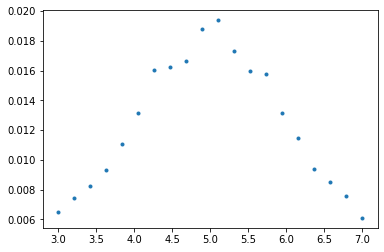

In [284]:
pl.plot(t0grid, r, '.')

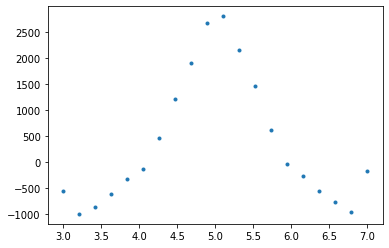

In [285]:
pl.plot(t0grid, ll - ll_notransit, '.')

In [14]:
mu = {'logS0':np.log(8e-11), 'logw':np.log(866), 'alpha':np.zeros(nb-1), 
      'logsig':np.log(wn_est), 'mean':np.ones(nb), 'u':[0.5, 0.5], 
      'logrp':np.log(0.0001), 'logrm':np.log(0.005), 't0p':10, 't0m':5}
sig = {'logS0':10, 'logw':10, 'logQ':None, 'alpha':np.ones(nb-1), 
       'logsig':np.ones(nb)*5, 'mean':np.ones(nb)*0.1, 't0p':1, 't0m':1, 'logrm':2}

with pm.Model() as model:
    logS0 = pm.Normal("logS0", mu=mu["logS0"], 
                        sd=sig["logS0"])
    logw = pm.Normal("logw", mu=mu["logw"], 
                       sd=sig["logw"])
    #alpha =  pm.MvNormal("alpha", mu=mu["alpha"], 
    #                      chol=np.diag(sig["alpha"]), shape=np.shape(data)[1]-1)
    logsig = pm.MvNormal("logsig", mu=mu["logsig"], 
                         chol=np.diag(sig["logsig"]), shape=np.shape(data)[1])
    mean = pm.MvNormal("mean", mu=mu["mean"], 
                       chol=np.diag(sig["mean"]), shape=np.shape(data)[1])
    #u = sgp.distributions.MvUniform("u", lower=[0, 0], upper=[1, 1], 
    #                                    testval=[0.5, 0.5])
    u1 = pm.Uniform("u1", lower=0, upper=1, testval=0.5)
    u2 = pm.Uniform("u2", lower=0, upper=1, testval=0.5)
    u = [u1, u2]
    #logrp = pm.Uniform("logrp", lower=-20.0, upper=0.0, testval=mu['logrp'], 
    #                       transform=None)
    #t0p = pm.Uniform("t0p", lower=t[0], upper=t[-1], testval=mu['t0p'], 
    #                     transform=None)
    logrm = pm.Normal("logrm", mu=mu['logrm'], sd=sig['logrm'],
                           transform=None)
    t0m = pm.Normal("t0m", mu=mu['t0m'], sd=sig['t0m'], testval=mu['t0m'], 
                         transform=None)
        
    orbit = xo.orbits.KeplerianOrbit(period=5.0*60*60)
    #lcp = (xo.LimbDarkLightCurve(u)
    #          .get_light_curve(orbit=orbit, r=np.exp(logrp), t=t/(60*60)-t0p, texp=np.mean(np.diff(t))/(60*60)))
    lcm = (xo.LimbDarkLightCurve(u)
              .get_light_curve(orbit=orbit, r=np.exp(logrm), t=t/(60*60)-t0m, texp=np.mean(np.diff(t))/(60*60)))
    mean = mean[:, None] + lcm.T[0]
    
    term = xo.gp.terms.SHOTerm(
            log_S0 = logS0,
            log_w0 = logw,
            log_Q = -np.log(np.sqrt(2))
        )
        
    #a = tt.exp(tt.concatenate([[0.0], alpha]))
        
    kernel = term #sgp.terms.KronTerm(term, alpha=a)
        
    yerr = tt.exp(2 * logsig)
    yerr = yerr[:, None] * tt.ones(len(t))
        
    gp = xo.gp.GP(kernel, t, yerr[0], J=2, mean=mean)
    marg = gp.marginal("gp", observed = obs.T)
        
    trace = pm.sample(
        tune=1000,
        draws=1000,
        start=model.test_point,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9)
    )

['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/s

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0m, logrm, u2, u1, mean, logsig, logw, logS0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3673 seconds.


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


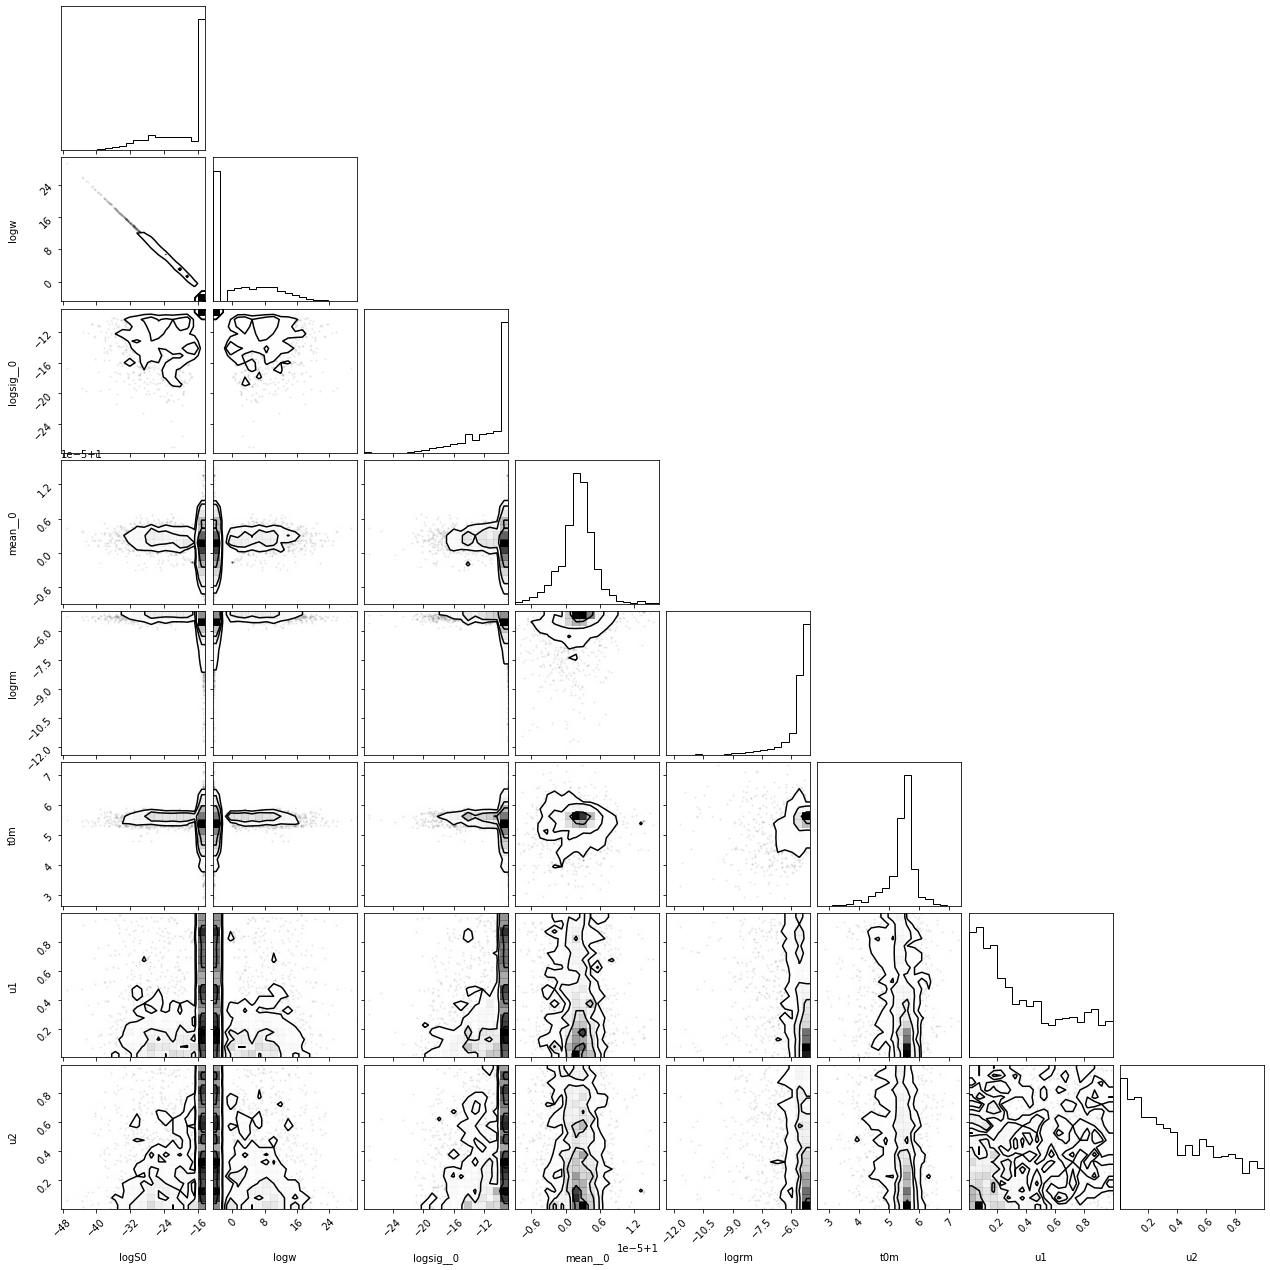

In [17]:
import corner
samples = pm.trace_to_dataframe(trace)
_ = corner.corner(samples)

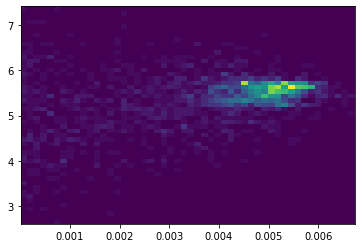

In [16]:
pl.hist2d(np.exp(trace['logrm']), trace['t0m'], bins=50);

In [20]:
with model:
    newtrace = pm.sample(
        tune=2000,
        draws=2000,
        start=trace[-1],
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9)
    )

['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0m, logrm, u2, u1, mean, logsig, logw, logS0]
INFO:pymc3:NUTS: [t0m, logrm, u2, u1, mean, logsig, logw, logS0]


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 5552 seconds.
INFO:pymc3:Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 5552 seconds.


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


(array([237.52370484, 173.95288359, 153.7258041 , 128.87539216,
        134.65455773, 138.12205707, 157.19330345, 153.14788755,
        197.06954586, 196.49162931, 198.22537898, 180.88788227,
        130.03122528,  72.81748615,  34.67499341,  19.07124637,
          4.0454159 ,   0.        ,   0.        ,   1.15583311]),
 array([9.08504540e-06, 4.41673448e-04, 8.74261850e-04, 1.30685025e-03,
        1.73943865e-03, 2.17202706e-03, 2.60461546e-03, 3.03720386e-03,
        3.46979226e-03, 3.90238067e-03, 4.33496907e-03, 4.76755747e-03,
        5.20014587e-03, 5.63273428e-03, 6.06532268e-03, 6.49791108e-03,
        6.93049948e-03, 7.36308789e-03, 7.79567629e-03, 8.22826469e-03,
        8.66085309e-03]),
 <BarContainer object of 20 artists>)

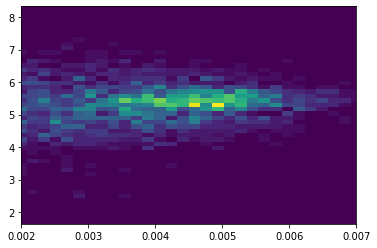

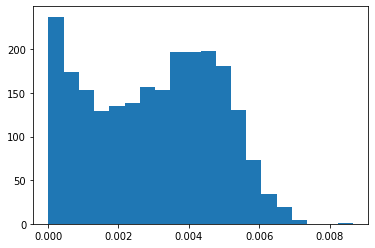

In [27]:
pl.hist2d(np.exp(newtrace['logrm']), newtrace['t0m'], bins=50);
pl.xlim(0.002, 0.007)
pl.figure()
pl.hist(np.exp(newtrace['logrm']), bins=20, density=True)

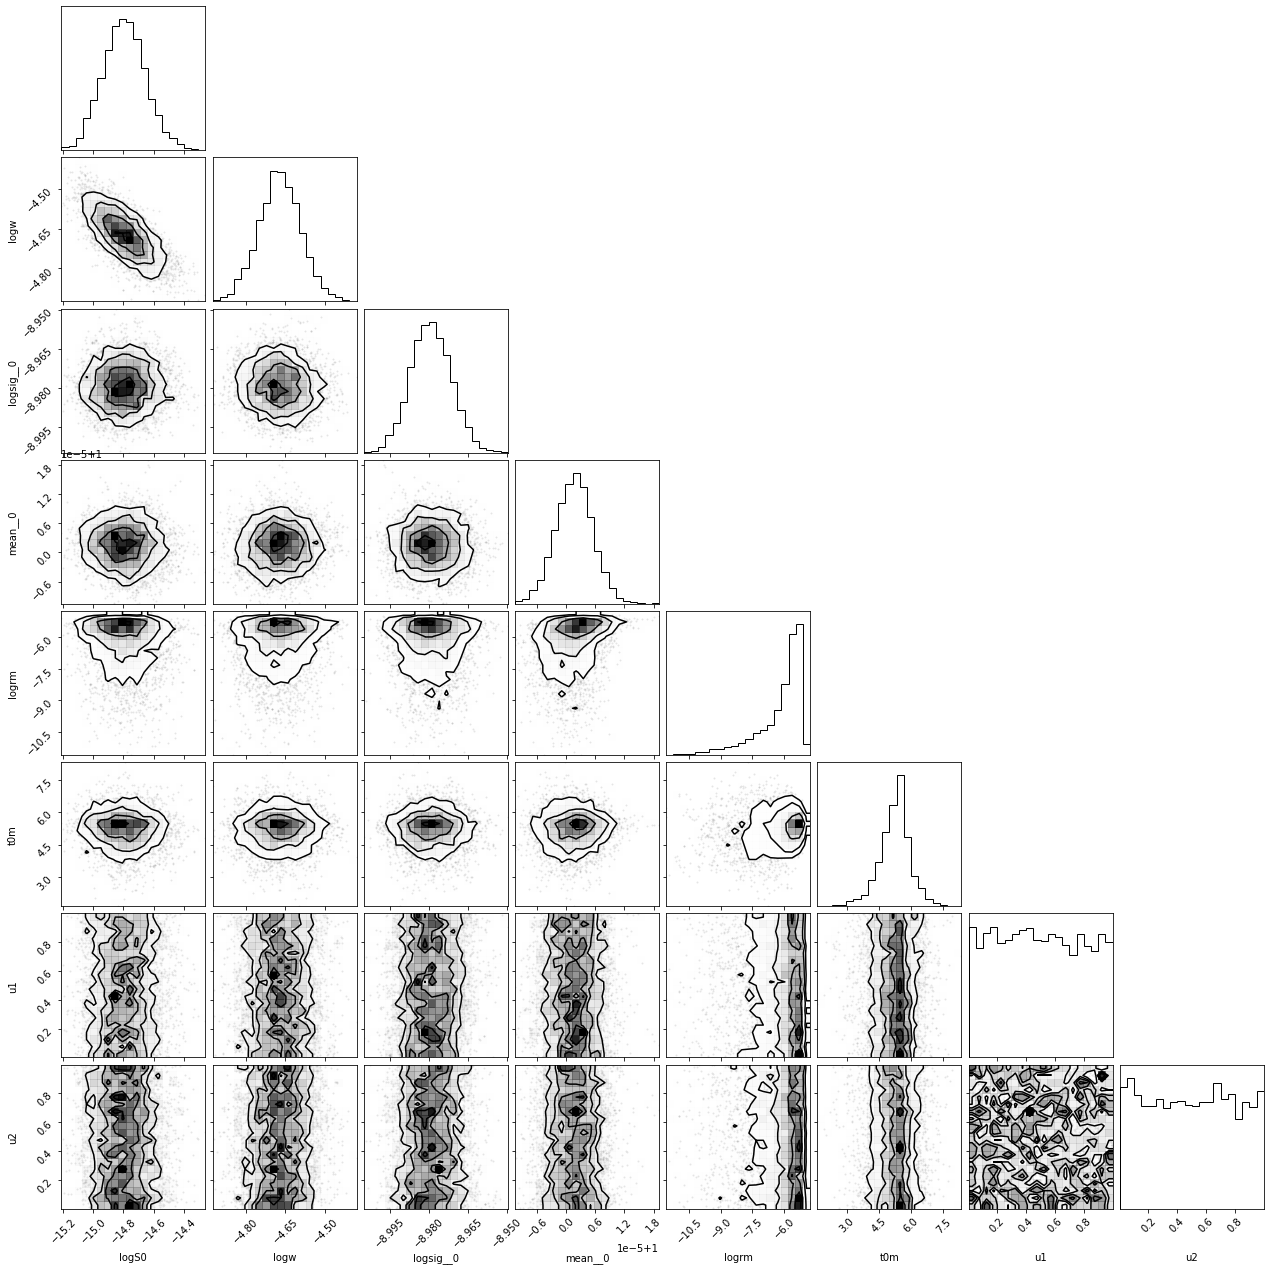

In [22]:
import corner
samples = pm.trace_to_dataframe(newtrace)
_ = corner.corner(samples)

In [23]:
pl.hist(np.exp(newtrace['alpha'][:,0]), bins=20);
pl.hist(np.exp(newtrace['alpha'][:,1]), bins=20);

KeyError: 'Unknown variable alpha'

In [243]:
from theano import config
config.optimizer_verbose

False

In [316]:
vars

namespace(NAME='Kepler-22 b',
          S0=2e-11,
          W0=886,
          T0P=10,
          T0M=5,
          RP=0.0203,
          RM=0.01,
          PPM=4.6459357998045e-05,
          FILTER='G140M/F100LP',
          MODE='BOTS')

In [350]:
xi2, t0 = np.loadtxt('xi2_Kepler-22b.txt').T

In [ ]:
pl.plot(t0, r, '.')

In [4]:
import matplotlib.pyplot as pl
ll, t0 = np.loadtxt('xi2_Kepler-22b.txt').T

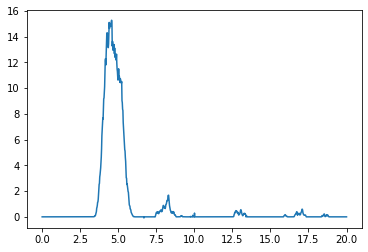

In [7]:
pl.plot(t0, ll, '-')